In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
import kerastuner as kt
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


C:\Users\neden\AppData\Local\Temp\ipykernel_4740\1995059879.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
height = 512

In [4]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Lambda(image=lambda x,**kwargs: x/255),
])

c:\Users\neden\miniconda3\envs\tf\lib\site-packages\albumentations\augmentations\transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [5]:
valdataset = DatasetCreator(val_transforms)

In [6]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [7]:
trainaugmentation = albu.Compose([
    albu.Resize(height,height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Lambda(image=lambda x,**kwargs: x/255),
])#todo change later

In [8]:
traindataset = DatasetCreator(trainaugmentation)

In [9]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

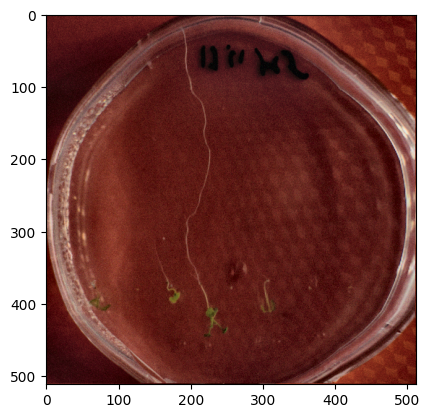

tf.Tensor(
[[[[0.3254902  0.07450981 0.08235294]
   [0.2901961  0.04705882 0.07450981]
   [0.28627452 0.05098039 0.06666667]
   ...
   [0.32941177 0.03921569 0.03529412]
   [0.2901961  0.01568628 0.00392157]
   [0.30980393 0.01568628 0.00784314]]

  [[0.30588236 0.07058824 0.08627451]
   [0.34901962 0.07450981 0.09019608]
   [0.3254902  0.07450981 0.09019608]
   ...
   [0.34117648 0.05882353 0.03137255]
   [0.3529412  0.05882353 0.03921569]
   [0.2509804  0.         0.        ]]

  [[0.3254902  0.07450981 0.08235294]
   [0.3137255  0.09019608 0.09411765]
   [0.38431373 0.10588235 0.09803922]
   ...
   [0.3019608  0.         0.01176471]
   [0.35686275 0.08627451 0.0627451 ]
   [0.2509804  0.00392157 0.        ]]

  ...

  [[0.28627452 0.0627451  0.07843138]
   [0.32941177 0.07843138 0.09803922]
   [0.3254902  0.08235294 0.09803922]
   ...
   [0.3764706  0.0627451  0.03529412]
   [0.35686275 0.01176471 0.01960784]
   [0.28627452 0.         0.        ]]

  [[0.31764707 0.09019608 0.094117

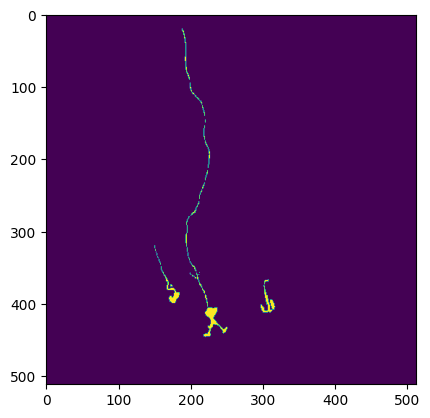

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(image)

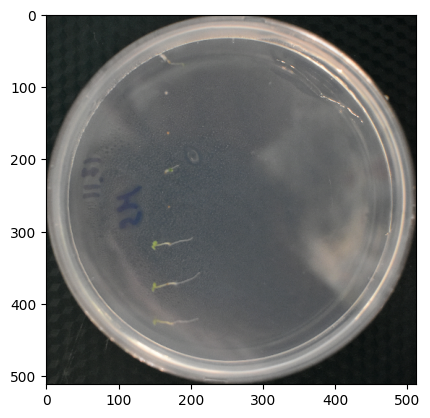

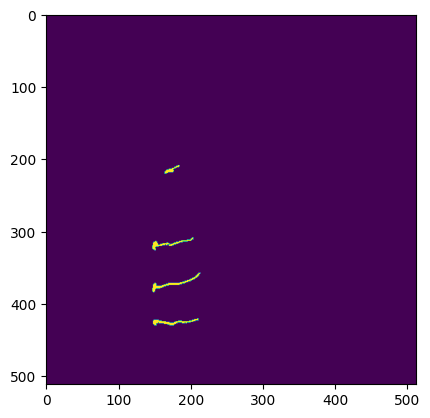

In [11]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [12]:
modelcreator = ModelCreator()

Adding tuner to train model and find the best params

In [13]:
tuner = kt.Hyperband(modelcreator.build_tunermodel,
                     objective=kt.Objective("val_iou_score", direction="max"),
                     max_epochs=50,
                     factor=3)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/Sigmoid:0', description="created by layer 'conv2d_transpose_5'")


In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', patience=30)]

In [15]:
tuner.search(traindata, epochs=200, validation_data=(valdata), callbacks=callbacks)

Trial 90 Complete [00h 08m 32s]
val_iou_score: 0.49282461404800415

Best val_iou_score So Far: 0.5731016993522644
Total elapsed time: 04h 09m 37s


In [16]:
best_hps = tuner.get_best_hyperparameters()[0]

best params: \
48 \
48 \
176 \
416 \
128 \
dropout = 0


In [17]:
model = tuner.hypermodel.build(best_hps)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_11/Sigmoid:0', description="created by layer 'conv2d_transpose_11'")


In [18]:
#tf.keras.utils.plot_model(model)

In [19]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='tunerbestmodel.h5',save_best_only=True,monitor='val_loss',verbose=1)
]

In [20]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000


20/20 [==============================] - ETA: 0s - loss: 1.2694 - iou_score: 0.0112
Epoch 1: val_loss improved from inf to 2.15538, saving model to tunerbestmodel.h5
20/20 [==============================] - 18s 319ms/step - loss: 1.2694 - iou_score: 0.0112 - val_loss: 2.1554 - val_iou_score: 0.0088 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 0.9425 - iou_score: 0.0405
Epoch 2: val_loss improved from 2.15538 to 1.07360, saving model to tunerbestmodel.h5
20/20 [==============================] - 15s 285ms/step - loss: 0.9425 - iou_score: 0.0405 - val_loss: 1.0736 - val_iou_score: 0.0030 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 0.8697 - iou_score: 0.0833
Epoch 3: val_loss improved from 1.07360 to 1.02946, saving model to tunerbestmodel.h5
20/20 [=======

In [21]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [22]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 1s 19ms/step - loss: 0.3168 - iou_score: 0.5516


[0.31684422492980957, 0.5516217350959778]

[0.2888988256454468, 0.5814722776412964]

In [23]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 21ms/step
